<a href="https://colab.research.google.com/drive/1eQOkYB4XMQdSeHV_pKvt9kSUW8vQo6LQ">Abre este Jupyter en Google Colab</a>

# Regresión Logística: Detección de SPAM

En este ejercicio se muestran los fundamentos de la Regresión Logística planteando uno de los primeros problemas que fueron solucionados mediante el uso de técnicas de Machine Learning: la detección de SPAM.

## Enunciado del ejercicio

Se propone la construcción de un sistema de aprendizaje automático capaz de predecir si un correo determinado se corresponde con un correo de SPAM o no, para ello, se utilizará el siguiente conjunto de datos:

##### [2007 TREC Public Spam Corpus](https://plg.uwaterloo.ca/cgi-bin/cgiwrap/gvcormac/foo07)
The corpus trec07p contains 75,419 messages:

    25220 ham
    50199 spam

These messages constitute all the messages delivered to a particular
server between these dates:

    Sun, 8 Apr 2007 13:07:21 -0400
    Fri, 6 Jul 2007 07:04:53 -0400

### 0. Imports

In [1]:
# Instalación de librerías externas
!pip install scikit-learn
!pip install nltk

### 1. Funciones complementarias

En este caso práctico relacionado con la detección de correos electrónicos de SPAM, el conjunto de datos que disponemos esta formado por correos electrónicos, con sus correspondientes cabeceras y campos adicionales. Por lo tanto, requieren un preprocesamiento previo a que sean ingeridos por el algoritmo de Machine Learning.

In [4]:
# Esta clase facilita el preprocesamiento de correos electrónicos que poseen código HTML
from html.parser import HTMLParser

class MLStripper(HTMLParser):
    def __init__(self):
        self.reset()
        self.strict = False
        self.convert_charrefs = True
        self.fed = []

    def handle_data(self, d):
        self.fed.append(d)

    def get_data(self):
        return ''.join(self.fed)

In [5]:
# Esta función se encarga de elimar los tags HTML que se encuentren en el texto del correo electrónico
def strip_tags(html):
    s = MLStripper()
    s.feed(html)
    return s.get_data()

In [6]:
# Ejemplo de eliminación de los tags HTML de un texto
t = '<tr><td align="left"><a href="../../issues/51/16.html#article">Phrack World News</a></td>'
strip_tags(t)

'Phrack World News'

Además de eliminar los posibles tags HTML que se encuentren en el correo electrónico, deben realizarse otras acciones de preprocesamiento para evitar que los mensajes contengan ruido innecesario. Entre ellas se encuentra la eliminación de los signos de puntuación, eliminación de posibles campos del correo electrónico que no son relevantes o eliminación de los afijos de una palabra manteniendo únicamente la raiz de la misma (Stemming). La clase que se muestra a continuación realiza estas transformaciones.

In [12]:
import email
import string
import nltk
nltk.download('stopwords')

class Parser:

    def __init__(self):
        self.stemmer = nltk.PorterStemmer()
        self.stopwords = set(nltk.corpus.stopwords.words('english'))
        self.punctuation = list(string.punctuation)

    def parse(self, email_path):
        """Parse an email."""
        with open(email_path, errors='ignore') as e:
            msg = email.message_from_file(e)
        return None if not msg else self.get_email_content(msg)

    def get_email_content(self, msg):
        """Extract the email content."""
        subject = self.tokenize(msg['Subject']) if msg['Subject'] else []
        body = self.get_email_body(msg.get_payload(),
                                   msg.get_content_type())
        content_type = msg.get_content_type()
        # Returning the content of the email
        return {"subject": subject,
                "body": body,
                "content_type": content_type}

    def get_email_body(self, payload, content_type):
        """Extract the body of the email."""
        body = []
        if type(payload) is str and content_type == 'text/plain':
            return self.tokenize(payload)
        elif type(payload) is str and content_type == 'text/html':
            return self.tokenize(strip_tags(payload))
        elif type(payload) is list:
            for p in payload:
                body += self.get_email_body(p.get_payload(),
                                            p.get_content_type())
        return body

    def tokenize(self, text):
        """Transform a text string in tokens. Perform two main actions,
        clean the punctuation symbols and do stemming of the text."""
        for c in self.punctuation:
            text = text.replace(c, "")
        text = text.replace("\t", " ")
        text = text.replace("\n", " ")
        tokens = list(filter(None, text.split(" ")))
        # Stemming of the tokens
        return [self.stemmer.stem(w) for w in tokens if w not in self.stopwords]

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rodri\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


##### Lectura de un correo en formato raw

##### Parsing del correo electrónico

In [15]:
p = Parser()
p.parse("datasets/trec07p/data/inmail.1")

{'subject': ['gener', 'ciali', 'brand', 'qualiti'],
 'body': ['do',
  'feel',
  'pressur',
  'perform',
  'rise',
  'occas',
  'tri',
  'viagra',
  'anxieti',
  'thing',
  'past',
  'back',
  'old',
  'self'],
 'content_type': 'multipart/alternative'}

##### Lectura del índice

Estas funciones complementarias se encargan cargar en memoria la ruta de cada correo electrónico y su etiqueta correspondiente {spam, ham}

In [20]:
index = open("datasets/trec07p/full/index").readlines()
##index

In [22]:
import os

DATASET_PATH = os.path.join("datasets", "trec07p")

def parse_index(path_to_index, n_elements):
    ret_indexes = []
    index = open(path_to_index).readlines()
    for i in range(n_elements):
        mail = index[i].split(" ../")
        label = mail[0]
        path = mail[1][:-1]
        path_mail = path.split("/")[-1]
        ret_indexes.append({"label":label, "email_path":os.path.join(DATASET_PATH, os.path.join("data", path_mail))})
    return ret_indexes

In [24]:
def parse_email(index):
    p = Parser()
    pmail = p.parse(index["email_path"])
    return pmail, index["label"]

In [26]:
indexes = parse_index("datasets/trec07p/full/index", 10)
indexes

[{'label': 'spam', 'email_path': 'datasets\\trec07p\\data\\inmail.1'},
 {'label': 'ham', 'email_path': 'datasets\\trec07p\\data\\inmail.2'},
 {'label': 'spam', 'email_path': 'datasets\\trec07p\\data\\inmail.3'},
 {'label': 'spam', 'email_path': 'datasets\\trec07p\\data\\inmail.4'},
 {'label': 'spam', 'email_path': 'datasets\\trec07p\\data\\inmail.5'},
 {'label': 'spam', 'email_path': 'datasets\\trec07p\\data\\inmail.6'},
 {'label': 'spam', 'email_path': 'datasets\\trec07p\\data\\inmail.7'},
 {'label': 'spam', 'email_path': 'datasets\\trec07p\\data\\inmail.8'},
 {'label': 'spam', 'email_path': 'datasets\\trec07p\\data\\inmail.9'},
 {'label': 'ham', 'email_path': 'datasets\\trec07p\\data\\inmail.10'}]

### 2. Preprocesamiento de los datos del conjunto de datos

Con las funciones presentadas anteriormente se permite la lectura de los correos electrónicos de manera programática y el procesamiento de los mismos para eliminar aquellos componentes que no resultan de utilidad para la detección de correos de SPAM. Sin embargo, cada uno de los correos sigue estando representado por un diccionario de Python con una serie de palabras.

In [30]:
# Cargamos el índice y las etiquetas en memoria
index = parse_index("datasets/trec07p/full/index", 1)

In [32]:
# Leemos el primer correo
import os

open(index[0]["email_path"]).read()

'From RickyAmes@aol.com  Sun Apr  8 13:07:32 2007\nReturn-Path: <RickyAmes@aol.com>\nReceived: from 129.97.78.23 ([211.202.101.74])\n\tby speedy.uwaterloo.ca (8.12.8/8.12.5) with SMTP id l38H7G0I003017;\n\tSun, 8 Apr 2007 13:07:21 -0400\nReceived: from 0.144.152.6 by 211.202.101.74; Sun, 08 Apr 2007 19:04:48 +0100\nMessage-ID: <WYADCKPDFWWTWTXNFVUE@yahoo.com>\nFrom: "Tomas Jacobs" <RickyAmes@aol.com>\nReply-To: "Tomas Jacobs" <RickyAmes@aol.com>\nTo: the00@speedy.uwaterloo.ca\nSubject: Generic Cialis, branded quality@ \nDate: Sun, 08 Apr 2007 21:00:48 +0300\nX-Mailer: Microsoft Outlook Express 6.00.2600.0000\nMIME-Version: 1.0\nContent-Type: multipart/alternative;\n\tboundary="--8896484051606557286"\nX-Priority: 3\nX-MSMail-Priority: Normal\nStatus: RO\nContent-Length: 988\nLines: 24\n\n----8896484051606557286\nContent-Type: text/html;\nContent-Transfer-Encoding: 7Bit\n\n<html>\n<body bgcolor="#ffffff">\n<div style="border-color: #00FFFF; border-right-width: 0px; border-bottom-width: 0

In [34]:
# Parseamos el primer correo
mail, label = parse_email(index[0])
print("El correo es:", label)
print(mail)

El correo es: spam
{'subject': ['gener', 'ciali', 'brand', 'qualiti'], 'body': ['do', 'feel', 'pressur', 'perform', 'rise', 'occas', 'tri', 'viagra', 'anxieti', 'thing', 'past', 'back', 'old', 'self'], 'content_type': 'multipart/alternative'}


El algoritmo de Regresión Logística no es capaz de ingerir texto como parte del conjunto de datos. Por lo tanto, deben aplicarse una serie de funciones adicionales que transformen el texto de los correos electrónicos parseados en una representación numérica.

##### Aplicación de CountVectorizer

In [38]:
from sklearn.feature_extraction.text import CountVectorizer

# Preapración del email en una cadena de texto
prep_email = [" ".join(mail['subject']) + " ".join(mail['body'])]

vectorizer = CountVectorizer()
X = vectorizer.fit(prep_email)

print("Email:", prep_email, "\n")
print("Características de entrada:", vectorizer.get_feature_names_out())

Email: ['gener ciali brand qualitido feel pressur perform rise occas tri viagra anxieti thing past back old self'] 

Características de entrada: ['anxieti' 'back' 'brand' 'ciali' 'feel' 'gener' 'occas' 'old' 'past'
 'perform' 'pressur' 'qualitido' 'rise' 'self' 'thing' 'tri' 'viagra']


In [40]:
X = vectorizer.transform(prep_email)
print("\nValues:\n", X.toarray())


Values:
 [[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]]


##### Aplicación de OneHotEncoding

In [43]:
from sklearn.preprocessing import OneHotEncoder

prep_email = [[w] for w in mail['subject'] + mail['body']]

enc = OneHotEncoder(handle_unknown='ignore')
X = enc.fit_transform(prep_email)

print("Features:\n", enc.get_feature_names_out())
print("\nValues:\n", X.toarray())

Features:
 ['x0_anxieti' 'x0_back' 'x0_brand' 'x0_ciali' 'x0_do' 'x0_feel' 'x0_gener'
 'x0_occas' 'x0_old' 'x0_past' 'x0_perform' 'x0_pressur' 'x0_qualiti'
 'x0_rise' 'x0_self' 'x0_thing' 'x0_tri' 'x0_viagra']

Values:
 [[0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

##### Funciones auxiliares para preprocesamiento del conjunto de datos

In [46]:
def create_prep_dataset(index_path, n_elements):
    X = []
    y = []
    indexes = parse_index(index_path, n_elements)
    for i in range(n_elements):
        print("\rParsing email: {0}".format(i+1), end='')
        try:
            mail, label = parse_email(indexes[i])
            X.append(" ".join(mail['subject']) + " ".join(mail['body']))
            y.append(label)
        except:
            pass
    #print("X:", X[:15])
    #print("y:", y[:15])
    return X, y

### 3. Entrenamiento del algoritmo 

In [49]:
# Leemos únicamente un subconjunto de 100 correos electrónicos
X_train, y_train = create_prep_dataset("datasets/trec07p/full/index", 500)

Parsing email: 500

##### Aplicamos la vectorización a los datos

In [51]:
vectorizer = CountVectorizer(max_features=20, min_df=2, max_df=0.9)
X_train = vectorizer.fit_transform(X_train)

In [54]:
##print(X_train.toarray())
##print("\nFeatures:", len(vectorizer.get_feature_names_out()))

In [56]:
import pandas as pd
pd.DataFrame(X_train.toarray(), columns=[vectorizer.get_feature_names_out()])

,as,ciali,day,for,it,know,men,much,new,one,price,product,said,the,thi,time,use,viagra,work,you
0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,0,0,0,0,0,1,0,0,0,2,0,0,1,1,0,1,2,0,0,0
4,2,0,0,0,4,4,0,4,4,0,2,0,0,0,2,2,0,0,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
488,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
489,0,0,1,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0
490,0,0,1,1,0,0,0,0,0,1,2,0,0,0,0,0,0,0,0,1
491,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [58]:
y_train

['spam',
 'ham',
 'spam',
 'spam',
 'spam',
 'spam',
 'spam',
 'spam',
 'spam',
 'ham',
 'spam',
 'spam',
 'spam',
 'spam',
 'spam',
 'spam',
 'spam',
 'spam',
 'spam',
 'ham',
 'ham',
 'spam',
 'spam',
 'spam',
 'spam',
 'spam',
 'spam',
 'spam',
 'ham',
 'spam',
 'ham',
 'spam',
 'spam',
 'ham',
 'spam',
 'spam',
 'spam',
 'spam',
 'spam',
 'spam',
 'spam',
 'spam',
 'spam',
 'spam',
 'spam',
 'spam',
 'spam',
 'spam',
 'ham',
 'ham',
 'spam',
 'spam',
 'spam',
 'spam',
 'spam',
 'spam',
 'ham',
 'spam',
 'ham',
 'spam',
 'spam',
 'ham',
 'spam',
 'spam',
 'spam',
 'ham',
 'ham',
 'spam',
 'spam',
 'spam',
 'ham',
 'ham',
 'ham',
 'spam',
 'ham',
 'spam',
 'ham',
 'spam',
 'spam',
 'spam',
 'ham',
 'spam',
 'spam',
 'ham',
 'spam',
 'ham',
 'spam',
 'spam',
 'ham',
 'spam',
 'spam',
 'spam',
 'spam',
 'spam',
 'spam',
 'spam',
 'spam',
 'spam',
 'spam',
 'spam',
 'spam',
 'spam',
 'spam',
 'spam',
 'spam',
 'spam',
 'spam',
 'ham',
 'spam',
 'spam',
 'spam',
 'spam',
 'spam',
 'ham',

###### Entrenamiento del algoritmo de regresión logística con el conjunto de datos preprocesado

In [61]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()
clf.fit(X_train, y_train)

LogisticRegression()

### 4. Predicción

##### Lectura de un conjunto de correos nuevos

In [65]:
# Leemos 150 correos de nuestro conjunto de datos y nos quedamos únicamente con los 50 últimos 
# Estos 50 correos electrónicos no se han utilizado para entrenar el algoritmo

# Si deseo incrementar el numero de correos
# X_train, y_train = create_prep_dataset("datasets/trec07p/full/index", 1000)


X_test = X_train[100:]
y_test = y_train[100:]

##### Preprocesamiento de los correos con el vectorizador creado anteriormente

In [68]:
# X_test = vectorizer.transform(X_test)

##### Predicción del tipo de correo

In [71]:
y_pred = clf.predict(X_test)
y_pred

array(['spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'ham',
       'spam', 'spam', 'spam', 'spam', 'spam', 'ham', 'spam', 'spam',
       'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam',
       'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam',
       'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam',
       'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam',
       'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam',
       'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam',
       'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam',
       'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam',
       'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam',
       'ham', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam',
       'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'ham', 'spam',
       'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam',
       'sp

In [73]:
print("Predicción:\n", y_pred)
print("\nEtiquetas reales:\n", y_test)

Predicción:
 ['spam' 'spam' 'spam' 'spam' 'spam' 'spam' 'spam' 'ham' 'spam' 'spam'
 'spam' 'spam' 'spam' 'ham' 'spam' 'spam' 'spam' 'spam' 'spam' 'spam'
 'spam' 'spam' 'spam' 'spam' 'spam' 'spam' 'spam' 'spam' 'spam' 'spam'
 'spam' 'spam' 'spam' 'spam' 'spam' 'spam' 'spam' 'spam' 'spam' 'spam'
 'spam' 'spam' 'spam' 'spam' 'spam' 'spam' 'spam' 'spam' 'spam' 'spam'
 'spam' 'spam' 'spam' 'spam' 'spam' 'spam' 'spam' 'spam' 'spam' 'spam'
 'spam' 'spam' 'spam' 'spam' 'spam' 'spam' 'spam' 'spam' 'spam' 'spam'
 'spam' 'spam' 'spam' 'spam' 'spam' 'spam' 'spam' 'spam' 'spam' 'spam'
 'spam' 'spam' 'spam' 'spam' 'spam' 'spam' 'spam' 'spam' 'ham' 'spam'
 'spam' 'spam' 'spam' 'spam' 'spam' 'spam' 'spam' 'spam' 'spam' 'spam'
 'spam' 'spam' 'ham' 'spam' 'spam' 'spam' 'spam' 'spam' 'spam' 'spam'
 'spam' 'spam' 'spam' 'spam' 'spam' 'spam' 'spam' 'spam' 'spam' 'spam'
 'spam' 'spam' 'spam' 'ham' 'spam' 'spam' 'spam' 'spam' 'spam' 'ham' 'ham'
 'spam' 'ham' 'spam' 'spam' 'spam' 'spam' 'spam' 'spam' 'spam' '

##### Evaluación de los resultados

In [76]:
from sklearn.metrics import accuracy_score

print('Accuracy: {:.3f}'.format(accuracy_score(y_test, y_pred)))

Accuracy: 0.885


## Seleccion de Caracteristicas con Random Forest

In [79]:
# Carga y preprocesamiento de los correos
X_train_text, y_train_text = create_prep_dataset("datasets/trec07p/full/index", 200)

Parsing email: 200

In [80]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

# Paso 1: Vectorización completa (todas las palabras)
vectorizer = CountVectorizer()
X_all = vectorizer.fit_transform(X_train_text)
feature_names = np.array(vectorizer.get_feature_names_out())

# Paso 2: Random Forest para selección de características
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_all, y_train_text)

# Paso 3: Obtener importancias de características
importances = rf.feature_importances_

# Ordenamos por importancia
indices = np.argsort(importances)[::-1]
top_n = 20  # Número de palabras importantes a seleccionar
top_features = feature_names[indices[:top_n]]

print(f"Top {top_n} palabras importantes según Random Forest:")
for i, feature in enumerate(top_features):
    print(f"{i+1}. {feature} ({importances[indices[i]]:.4f})")

# Paso 4: Vectorización solo con top features
vectorizer_top = CountVectorizer(vocabulary=top_features)
X_top = vectorizer_top.fit_transform(X_train_text)

# Paso 5: Entrenar regresión logística con solo esas características
clf = LogisticRegression()
clf.fit(X_top, y_train_text)

# Mostrar coeficientes aprendidos
print("\nCoeficientes aprendidos por la Regresión Logística:")
for word, coef in zip(top_features, clf.coef_[0]):
    print(f"{word}: {coef:.4f}")

Top 20 palabras importantes según Random Forest:
1. perl (0.0290)
2. selfcontain (0.0187)
3. string (0.0176)
4. cochran (0.0132)
5. mail (0.0130)
6. code (0.0123)
7. unsubscrib (0.0118)
8. comment (0.0113)
9. pleas (0.0113)
10. correspond (0.0112)
11. implement (0.0107)
12. opnew (0.0105)
13. post (0.0104)
14. 08 (0.0092)
15. httpwwwrprojectorgpostingguidehtml (0.0092)
16. reproduc (0.0091)
17. todo (0.0088)
18. read (0.0085)
19. minim (0.0084)
20. line (0.0083)

Coeficientes aprendidos por la Regresión Logística:
perl: -1.1901
selfcontain: -0.4406
string: -0.5361
cochran: -0.5293
mail: -0.7823
code: -0.6144
unsubscrib: -2.3516
comment: -0.5997
pleas: -0.2353
correspond: -0.5293
implement: -0.2788
opnew: -0.3786
post: -0.6088
08: -1.6845
httpwwwrprojectorgpostingguidehtml: -0.4406
reproduc: -0.4406
todo: -0.4294
read: -0.7649
minim: -0.3734
line: 0.0175


## Vectorizar con caracteristicas seleccionadas

In [84]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

# Paso 1: Vectorización completa (todas las palabras)
vectorizer = CountVectorizer()
X_all = vectorizer.fit_transform(X_train_text)  # X_train_text es tu conjunto de texto
feature_names = np.array(vectorizer.get_feature_names_out())

# Paso 2: Random Forest para selección de características
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_all, y_train_text)

# Paso 3: Obtener importancias de características
importances = rf.feature_importances_

# Ordenamos por importancia y seleccionamos las 29 características más importantes
indices = np.argsort(importances)[::-1]
top_n = 20  # Seleccionar las 29 características más importantes
top_features = feature_names[indices[:top_n]]

# Paso 4: Vectorización solo con las 29 características más importantes
vectorizer_top = CountVectorizer(vocabulary=top_features)
X_top = vectorizer_top.fit_transform(X_train_text)

# Ahora X_top contiene solo las 29 características más importantes


In [86]:
# Entrenamos un modelo de regresión logística sobre las 29 características seleccionadas
clf = LogisticRegression()
clf.fit(X_top, y_train_text)

# Hacemos predicciones
y_pred = clf.predict(X_top)

# Evaluamos el modelo (por ejemplo, precisión)
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_train_text, y_pred)
print(f"Precisión con las 20 características seleccionadas: {accuracy:.4f}")


Precisión con las 20 características seleccionadas: 0.9490


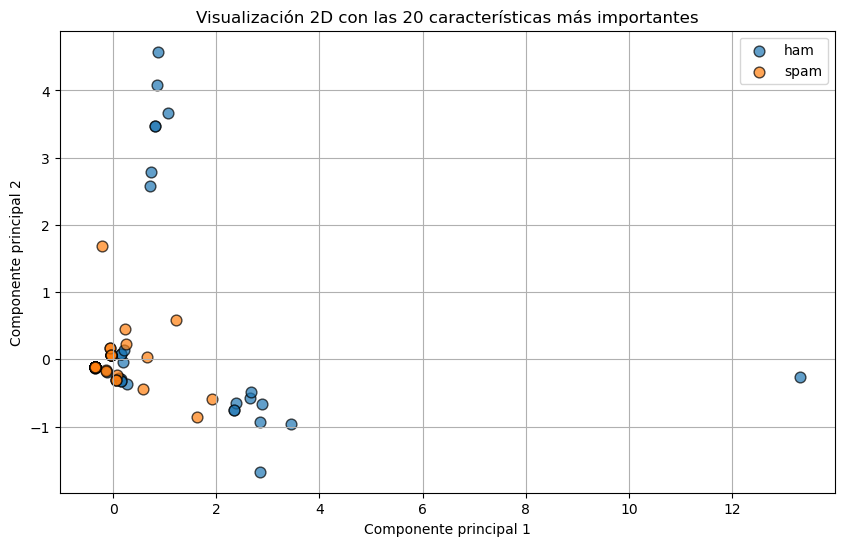

In [88]:
from sklearn.decomposition import PCA

# Reducción de dimensionalidad a 2D
pca = PCA(n_components=2)
X_2d = pca.fit_transform(X_top.toarray())

# Graficar en 2D
plt.figure(figsize=(10, 6))
for label in np.unique(y_train):
    idx = np.array(y_train_text) == label
    plt.scatter(X_2d[idx, 0], X_2d[idx, 1], label=label, edgecolors='k', s=60, alpha=0.7)

plt.title("Visualización 2D con las 20 características más importantes")
plt.xlabel("Componente principal 1")
plt.ylabel("Componente principal 2")
plt.legend()
plt.grid(True)
plt.show()


In [90]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train_text)

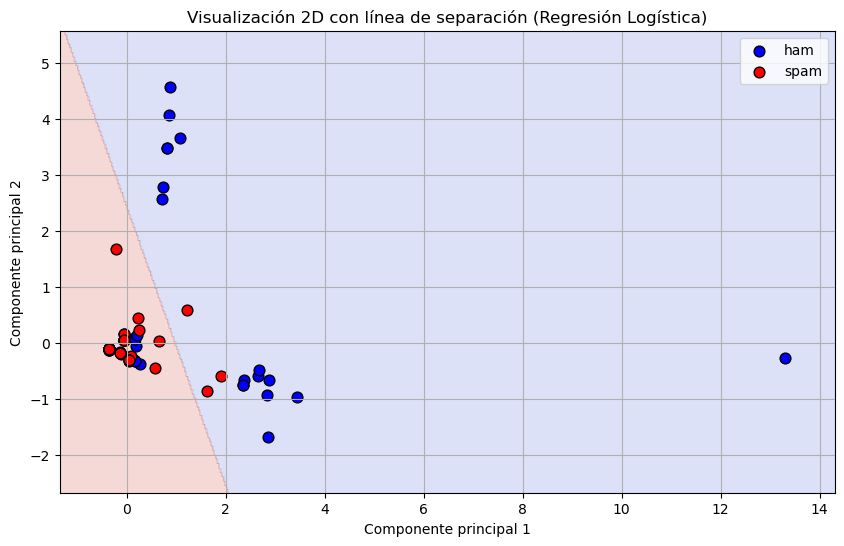

In [92]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA

# Reducción de dimensionalidad
pca = PCA(n_components=2)
X_2d = pca.fit_transform(X_top.toarray())

# Entrenar un clasificador en 2D
clf = LogisticRegression()
clf.fit(X_2d, y_train_encoded)  # y_train_encoded es numérico (0 o 1)

# Crear una malla de puntos para graficar la frontera
x_min, x_max = X_2d[:, 0].min() - 1, X_2d[:, 0].max() + 1
y_min, y_max = X_2d[:, 1].min() - 1, X_2d[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 500),
                     np.linspace(y_min, y_max, 500))
grid_points = np.c_[xx.ravel(), yy.ravel()]

# Predecir en cada punto de la malla
Z = clf.predict(grid_points)
Z = Z.reshape(xx.shape)

# Graficar
plt.figure(figsize=(10, 6))
plt.contourf(xx, yy, Z, alpha=0.2, cmap=plt.cm.coolwarm)

# Puntos reales
colors = ['blue', 'red']
for i, label in enumerate(label_encoder.classes_):  # spam / ham
    idx = y_train_encoded == i
    plt.scatter(X_2d[idx, 0], X_2d[idx, 1], c=colors[i], label=label, edgecolors='k', s=60)

plt.title("Visualización 2D con línea de separación (Regresión Logística)")
plt.xlabel("Componente principal 1")
plt.ylabel("Componente principal 2")
plt.legend()
plt.grid(True)
plt.show()
